In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np

# Tratamento de Dados

In [2]:
# Arquivo Excel
file_path = r'C:\Users\Salvador\Desktop\Afonso\Tese\Dados\ISEG_Bloomberg\Dados.xlsx'

In [3]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

Relativamente aos dados presentes em cada folha de Excel deslocou-se uma linha para baixo (close price), porque quando os dados foram extraídos da Bloomberg no dia 17/07/2024 o dia ainda não tinha terminado, ou seja, o close price do dia 17/07 era o close price do dia anterior e assim sucessivamente, até ao close price mais antigo.

In [4]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
brent_data = read_sheet('Brent', 'Brent')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

Depois de ter usado todas as variáveis extraídas da Bloomberg e de as ter correlacionado decidi optar apenas por estas, tendo como variável dependente o WTI Crude Oil. O Jet Fuel NWE CIF Cargoes tem, tal como o Brent e como era de esperar, uma correlação de 0.99 com o WTI, no entanto, tem dados apenas desde 2008. A Bitcoin tem dados desde 2010 e tinha uma correlação de 0.10. A taxa de câmbio USD/RUB não tinha dados a partir de 2022 e ambas as moedas estão expostas ao EUR que mostra uma correlação considerável, daí ter optado por retirar do modelo. Por fim, as variáveis total crude oil supply & demand foram retiradas porque, apesar de terem uma correlação aparentemente considerável, têm apenas dados mensais e trimestrais.

In [5]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, brent_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Closing Prices das 5 variáveis

In [6]:
# Exibir os primeiros 5 registros
print(combined_data.head())

            WTI Crude Oil Prices  S&P500    Gold  Silver  Brent  EUR/USD  \
Date                                                                       
1994-01-04                 14.67  466.89  393.85    5.24  13.61   1.1246   
1994-01-05                 15.34  467.55  391.20    5.09  14.26   1.1252   
1994-01-06                 15.42  467.12  388.90    5.12  14.36   1.1252   
1994-01-07                 15.32  469.90  387.10    5.01  14.23   1.1293   
1994-01-10                 14.67  475.27  384.60    5.04  13.74   1.1269   

            EUR/RUB  
Date                 
1994-01-04   1.1088  
1994-01-05   1.1154  
1994-01-06   1.1189  
1994-01-07   1.1148  
1994-01-10   1.1305  


## Dados (1994-2024)

In [7]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-01-04'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [8]:
# Função para plotar cada variável
def plot_variable(data, variable_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[variable_name], label=variable_name)
    plt.title(f'{variable_name} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## Gráficos das variáveis

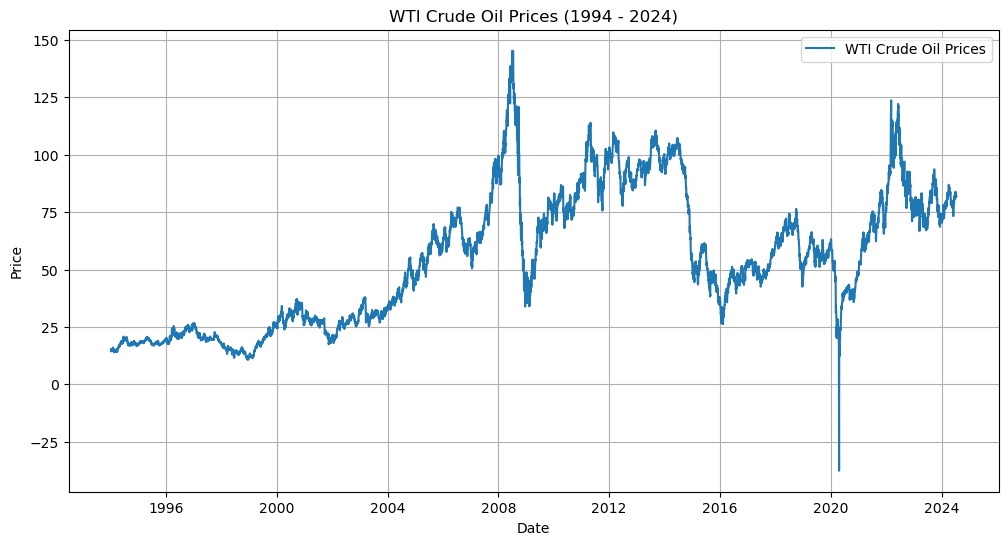

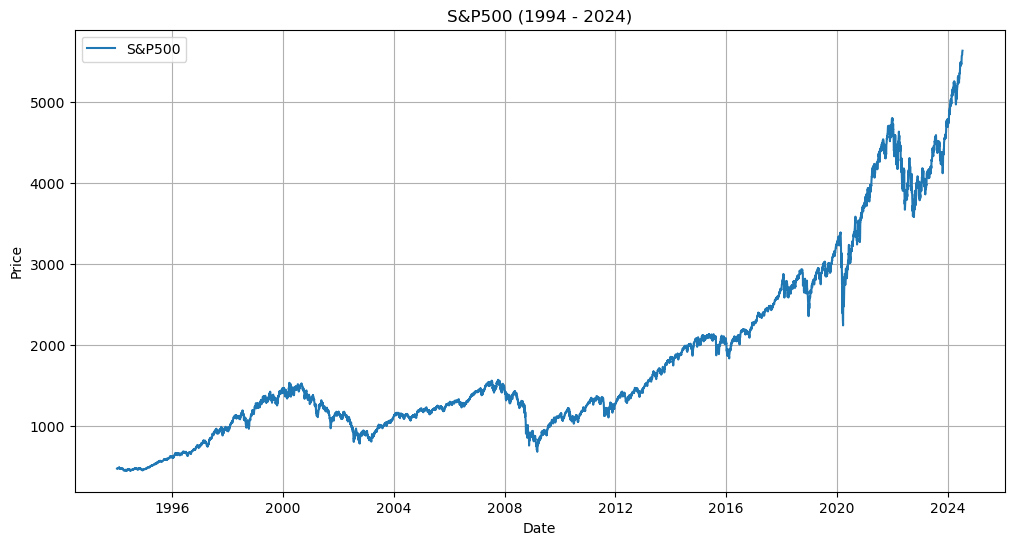

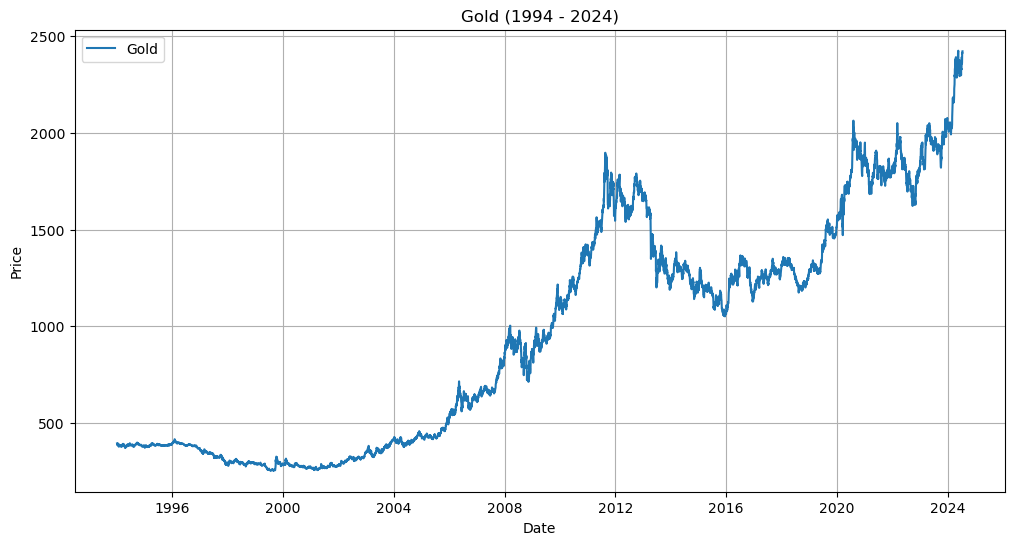

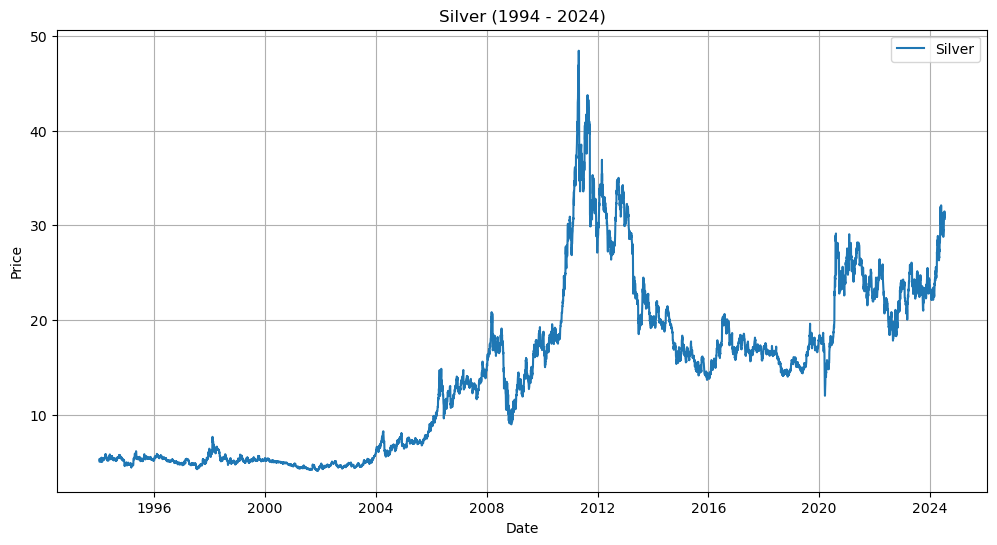

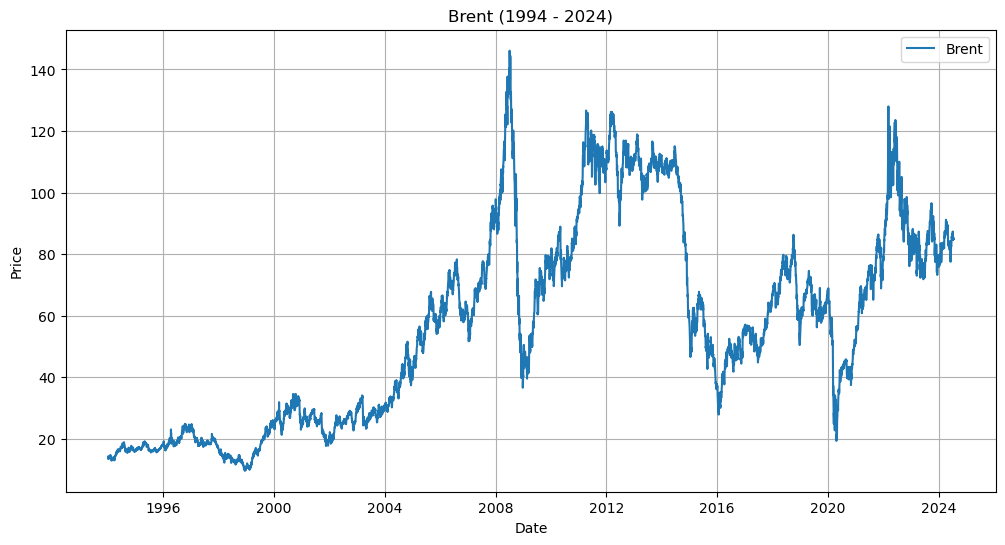

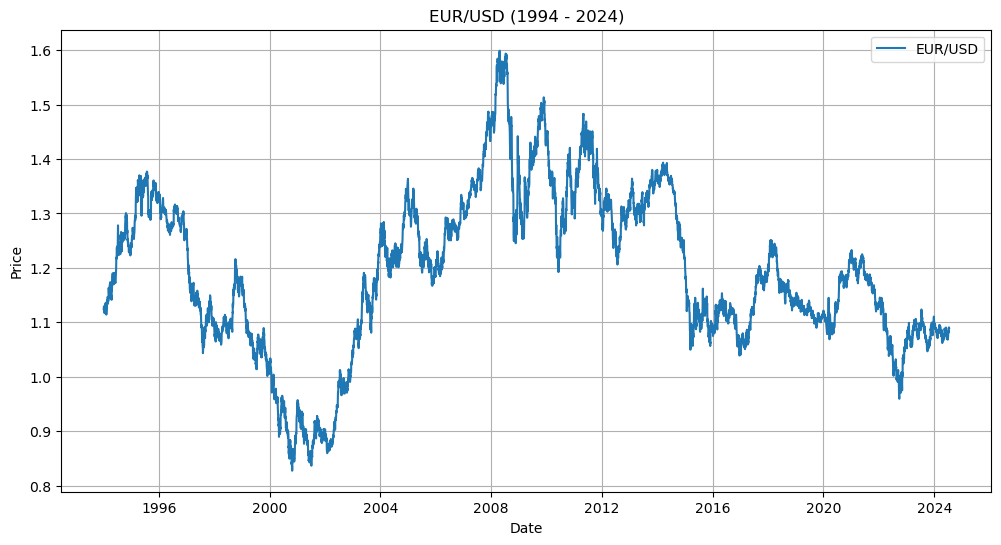

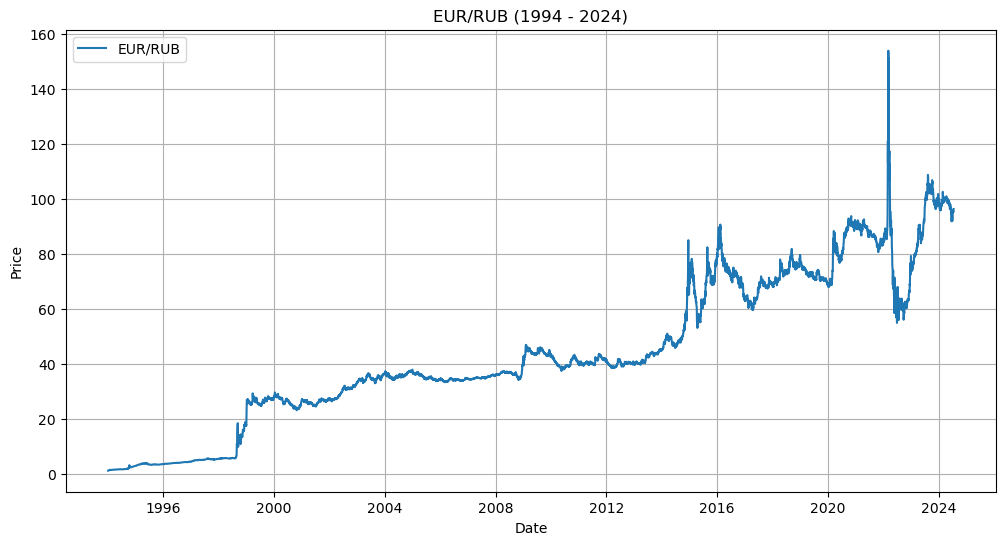

In [9]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'Brent', 'EUR/USD', 'EUR/RUB']
for var in variables:
    plot_variable(filtered_data, var)

## Describe das variáveis

In [10]:
# Descrever as variáveis
description = combined_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+------------------------+----------+----------+------------+-----------+-------------+-----------+
|       |   WTI Crude Oil Prices |   S&P500 |     Gold |     Silver |     Brent |     EUR/USD |   EUR/RUB |
|-------+------------------------+----------+----------+------------+-----------+-------------+-----------|
| count |              7601      |  7601    | 7601     | 7601       | 7601      | 7601        | 7601      |
| mean  |                54.9368 |  1809.75 |  963.887 |   14.3337  |   57.3906 |    1.19174  |   44.2331 |
| std   |                29.1107 |  1146.46 |  587.178 |    8.81567 |   32.5277 |    0.147932 |   26.8983 |
| min   |               -37.63   |   441.49 |  252.55  |    4.06    |    9.64   |    0.8272   |    1.1088 |
| 25%   |                27.63   |  1092.17 |  382.75  |    5.33    |   26.09   |    1.0922   |   27.3335 |
| 50%   |                53.13   |  1347.35 |  948.53  |   14.5505  |   56.35   |    1.1816   |   39.0733 |
| 75%   |                77.

## Matriz de Correlação (Heatmap)

In [11]:
# Calcular a matriz de correlação
correlation_matrix = combined_data.corr()

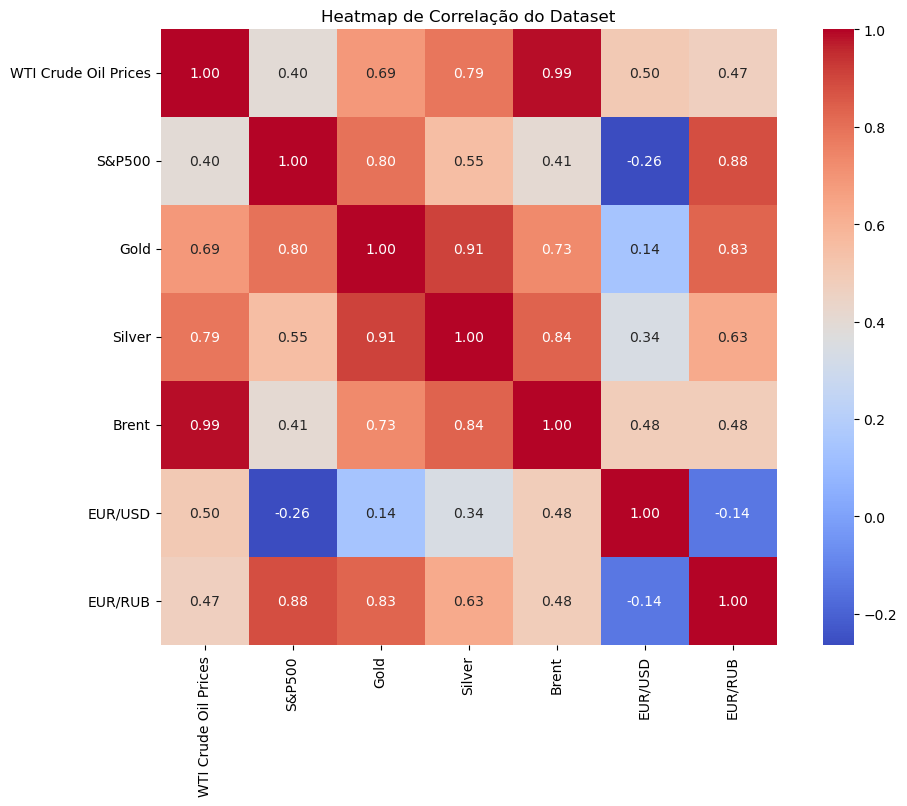

In [12]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelagem

## Creating Features and Target Variables

A variável a estudar é o WTI Crude Oil, com preços 1994 a 2024, e vamos definir vários horizontes
temporais, nomeadamente, 1, 7, 14, 21 e 30, ou seja, prever o preço do WTI para o próximo dia, para a 
próxima semana, para as próximas duas semanas, 3 semanas e para o próximo mês, usando um daily dataframe e uma window_size de 30 dias.

In [13]:
# Escalar os dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(filtered_data)

In [14]:
# Função para criar features e targets
def create_features_and_target(data, horizon_days, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon_days + 1):
        X.append(data[i:i+window_size].flatten())
        y.append(data[i+window_size+horizon_days-1][0])  # O target é o preço do WTI Crude Oil
    return np.array(X), np.array(y)

In [17]:
# Criar features e targets para cada horizonte
horizons = [1, 7, 14, 21, 30]
features_targets = {}
for horizon in horizons:
    X, y = create_features_and_target(scaled_data, horizon)
    features_targets[horizon] = (X, y)

In [18]:
# Imprimir as formas das features e targets para verificação
for horizon, (X, y) in features_targets.items():
    print(f"Horizon: {horizon} days")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}\n")

Horizon: 1 days
X shape: (7571, 210)
y shape: (7571,)

Horizon: 7 days
X shape: (7565, 210)
y shape: (7565,)

Horizon: 14 days
X shape: (7558, 210)
y shape: (7558,)

Horizon: 21 days
X shape: (7551, 210)
y shape: (7551,)

Horizon: 30 days
X shape: (7542, 210)
y shape: (7542,)



## Train-Test Split

No train-test split usou-se um rácio de 80/20

In [19]:
# Função para dividir os dados em conjuntos de treino e teste
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42)

In [20]:
# Dividir os dados para cada horizonte
split_data_dict = {}
for horizon in horizons:
    X, y = features_targets[horizon]
    split_data_dict[horizon] = split_data(X, y)

In [21]:
# Imprimir as formas dos conjuntos de treino e teste para verificação
for horizon, (X_train, X_test, y_train, y_test) in split_data_dict.items():
    print(f"Horizon: {horizon} days")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}\n")

Horizon: 1 days
X_train shape: (6056, 210)
X_test shape: (1515, 210)
y_train shape: (6056,)
y_test shape: (1515,)

Horizon: 7 days
X_train shape: (6052, 210)
X_test shape: (1513, 210)
y_train shape: (6052,)
y_test shape: (1513,)

Horizon: 14 days
X_train shape: (6046, 210)
X_test shape: (1512, 210)
y_train shape: (6046,)
y_test shape: (1512,)

Horizon: 21 days
X_train shape: (6040, 210)
X_test shape: (1511, 210)
y_train shape: (6040,)
y_test shape: (1511,)

Horizon: 30 days
X_train shape: (6033, 210)
X_test shape: (1509, 210)
y_train shape: (6033,)
y_test shape: (1509,)



## Métricas usadas (RMSE, MAPE, R^2 e MAE)

In [22]:
# Função para treinar e avaliar um modelo de regressão
def train_evaluate_regression(model, X_train, X_test, y_train, y_test, horizon):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Horizon: {horizon} days")
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")
    print(f"{model.__class__.__name__} MAPE: {mape:.4f}")
    print(f"{model.__class__.__name__} MSE: {mse:.4f}")
    print(f"{model.__class__.__name__} R²: {r2:.4f}\n")
    return model, y_pred

# Resultados

## Linear, Ridge, Lasso e Elastic Net Regressions

Inicialmente foram usados estes 4 modelos para testar o daily dataframe com os diferentes horizontes temporais (h=1, h=7, h=14, h=21 e h=30)

In [24]:
# Treinar e avaliar os modelos para cada horizonte
models = [LinearRegression(), Ridge(), Lasso(alpha=0.1), ElasticNet(alpha=0.1, l1_ratio=0.5)]
model_names = ["Linear Regression", "Ridge Regression", "Lasso Regression", "Elastic Net Regression"]
results = {name: {} for name in model_names}
for horizon in horizons:
    X_train, X_test, y_train, y_test = split_data_dict[horizon]
    for model, name in zip(models, model_names):
        trained_model, y_pred = train_evaluate_regression(model, X_train, X_test, y_train, y_test, horizon)
        results[name][horizon] = {
            "RMSE": mean_squared_error(y_test, y_pred, squared=False),
            "MAPE": mean_absolute_percentage_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R²": r2_score(y_test, y_pred)
        }

Horizon: 1 days
LinearRegression RMSE: 0.0101
LinearRegression MAPE: 0.0106
LinearRegression MSE: 0.0001
LinearRegression R²: 0.9959

Horizon: 1 days
Ridge RMSE: 0.0084
Ridge MAPE: 0.0110
Ridge MSE: 0.0001
Ridge R²: 0.9972

Horizon: 1 days
Lasso RMSE: 0.1585
Lasso MAPE: 0.3100
Lasso MSE: 0.0251
Lasso R²: -0.0028

Horizon: 1 days
ElasticNet RMSE: 0.1585
ElasticNet MAPE: 0.3100
ElasticNet MSE: 0.0251
ElasticNet R²: -0.0028

Horizon: 7 days
LinearRegression RMSE: 0.0205
LinearRegression MAPE: 0.0262
LinearRegression MSE: 0.0004
LinearRegression R²: 0.9835

Horizon: 7 days
Ridge RMSE: 0.0189
Ridge MAPE: 0.0254
Ridge MSE: 0.0004
Ridge R²: 0.9859

Horizon: 7 days
Lasso RMSE: 0.1596
Lasso MAPE: 0.3113
Lasso MSE: 0.0255
Lasso R²: -0.0011

Horizon: 7 days
ElasticNet RMSE: 0.1596
ElasticNet MAPE: 0.3113
ElasticNet MSE: 0.0255
ElasticNet R²: -0.0011

Horizon: 14 days
LinearRegression RMSE: 0.0272
LinearRegression MAPE: 0.0371
LinearRegression MSE: 0.0007
LinearRegression R²: 0.9711

Horizon: 14 d

## Tabela Resultados

In [25]:
# Criar tabelas para cada horizonte
from tabulate import tabulate
for horizon in horizons:
    table = [["Model", "RMSE", "MAPE", "MSE", "R²"]]
    for name in model_names:
        result = results[name][horizon]
        table.append([
            name,
            f"{result['RMSE']:.4f}",
            f"{result['MAPE']:.4f}",
            f"{result['MSE']:.4f}",
            f"{result['R²']:.4f}"
        ])
    print(f"\nResults for horizon: {horizon} days")
    print(tabulate(table, headers="firstrow", tablefmt="github"))


Results for horizon: 1 days
| Model                  |   RMSE |   MAPE |    MSE |      R² |
|------------------------|--------|--------|--------|---------|
| Linear Regression      | 0.0101 | 0.0106 | 0.0001 |  0.9959 |
| Ridge Regression       | 0.0084 | 0.011  | 0.0001 |  0.9972 |
| Lasso Regression       | 0.1585 | 0.31   | 0.0251 | -0.0028 |
| Elastic Net Regression | 0.1585 | 0.31   | 0.0251 | -0.0028 |

Results for horizon: 7 days
| Model                  |   RMSE |   MAPE |    MSE |      R² |
|------------------------|--------|--------|--------|---------|
| Linear Regression      | 0.0205 | 0.0262 | 0.0004 |  0.9835 |
| Ridge Regression       | 0.0189 | 0.0254 | 0.0004 |  0.9859 |
| Lasso Regression       | 0.1596 | 0.3113 | 0.0255 | -0.0011 |
| Elastic Net Regression | 0.1596 | 0.3113 | 0.0255 | -0.0011 |

Results for horizon: 14 days
| Model                  |   RMSE |   MAPE |    MSE |      R² |
|------------------------|--------|--------|--------|---------|
| Linear Regress